In [1]:
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import os
from dotenv import load_dotenv
import pandas as pd
import warnings
import joblib
import pickle

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

# Load client ID and secret from .env
load_dotenv('details.env')

client_id=os.getenv("SPOTIFY_CLIENT_ID")
client_secret=os.getenv("SPOTIFY_CLIENT_SECRET")

In [2]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id, client_secret=client_secret))

In [3]:
df1 = pd.read_csv(r"C:\Users\Ritik\Documents\GitHub\spotify\spotify-recommender\data\spotify_data_set_160k\data.csv")
df2 = pd.read_csv("flattened_json_first.csv")

In [4]:
df1.columns

Index(['id', 'name', 'artists', 'duration_ms', 'release_date', 'year',
       'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'mode',
       'key', 'popularity', 'explicit'],
      dtype='object')

In [5]:
df2.columns

Index(['name', 'collaborative', 'pid', 'modified_at', 'num_tracks',
       'num_albums', 'num_followers', 'pos', 'artist_name', 'track_uri',
       'track_name', 'album_uri', 'duration_ms', 'album_name'],
      dtype='object')

In [6]:
df2['id'] = df2['track_uri'].apply(lambda x: x.split(':')[2])
df2.id[1], df1['id'][1]

('6I9VzXrHxO9rA9A5euc8Ak', '0tMgFpOrXZR6irEOLNWwJL')

In [7]:
len(set(df2['id'])&set(df1['id']))

10350

In [8]:
len(set(df2['id'])), len(set(df1['id']))

(34443, 169907)

In [9]:
# df2.collaborative.value_counts()
# df2.pid.nunique()
# df2[['pid', 'num_tracks', 'num_albums']].value_counts()
# df2[df2['pid']==123]

In [10]:
jdf = pd.merge(df1, df2, on='id', how='inner')
jdf.shape

(29183, 33)

In [11]:
vc_df = jdf['pid'].value_counts().reset_index()

In [12]:
vc_df.columns = ['pid', 'num_songs']
vc_df[vc_df['num_songs']>10].shape

(684, 2)

<Axes: >

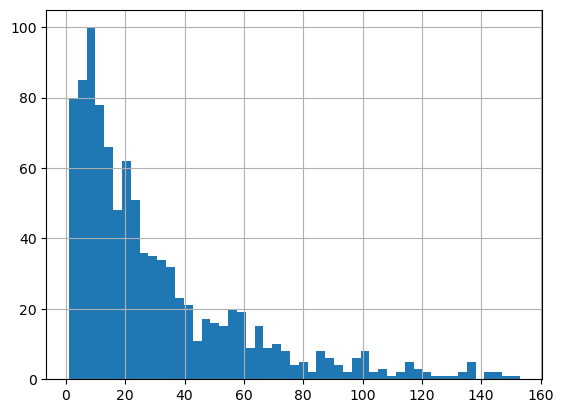

In [13]:
vc_df['num_songs'].hist(bins=51)

In [14]:
pid_list = vc_df[vc_df['num_songs']>10]['pid'].tolist()

In [15]:
jdf = jdf.drop(columns=['name_x', 'track_uri', 'artists', 'duration_ms_y',])

In [16]:
jdf2 = jdf[jdf['pid'].isin(pid_list)].copy()
jdf.shape, jdf2.shape

((29183, 29), (27498, 29))

In [17]:
jdf2.to_csv('kaggle_with_MPD_joined.csv', index=False)

In [18]:
jdf2.head(2)

,id,duration_ms_x,release_date,year,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,mode,key,popularity,explicit,name_y,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,pos,artist_name,track_name,album_uri,album_name
0,25Sd73fleKUVPNqITPZkn1,202493,1/1/12,2012,0.000696,0.315,0.970,0.0,0.277,-4.709,0.102,178.068,0.423,1,8,48,0,14,False,138,1400112000,130,119,1,30,The Gaslight Anthem,"""45""",spotify:album:1gsyJWUvwjnsNgYUxpOfLR,Handwritten
1,7rSj5gEdN5KgHwbnEVAZ4b,198760,6/25/02,2002,0.023600,0.690,0.592,0.0,0.560,-5.973,0.300,179.980,0.466,1,7,50,1,Thuggin,False,897,1479945600,70,10,1,42,Nelly,#1,spotify:album:4HUUHHXBXImwksfbSPqE7q,Nellyville


In [19]:
jdf2.columns

Index(['id', 'duration_ms_x', 'release_date', 'year', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness',
       'speechiness', 'tempo', 'valence', 'mode', 'key', 'popularity',
       'explicit', 'name_y', 'collaborative', 'pid', 'modified_at',
       'num_tracks', 'num_albums', 'num_followers', 'pos', 'artist_name',
       'track_name', 'album_uri', 'album_name'],
      dtype='object')

In [20]:
feature_cols = ['acousticness','danceability', 'energy', 'instrumentalness', 'liveness', 'loudness',
       'speechiness', 'tempo', 'valence', 'mode', 'key', 'popularity']

In [21]:
jdf2['collaborative'].value_counts()

collaborative
False    27002
True       496
Name: count, dtype: int64

In [22]:
jdf3 = jdf2.drop(columns=['id', 'release_date', 'year', 'modified_at', 'num_tracks', 'num_albums', 'num_followers', 'duration_ms_x', 'album_uri'])

In [23]:
jdf3.head(2)

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,mode,key,popularity,explicit,name_y,collaborative,pid,pos,artist_name,track_name,album_name
0,0.000696,0.315,0.970,0.0,0.277,-4.709,0.102,178.068,0.423,1,8,48,0,14,False,138,30,The Gaslight Anthem,"""45""",Handwritten
1,0.023600,0.690,0.592,0.0,0.560,-5.973,0.300,179.980,0.466,1,7,50,1,Thuggin,False,897,42,Nelly,#1,Nellyville


### Now here we can have a look at how we want to use featuers
1. Using mere feature cols, we will be able to find nearest neighbours.
2. Use the features like year, artist, album to tweak the results.

In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

class SongRecommenderAdaptor:
    required_features = ['acousticness','danceability', 'energy', 'instrumentalness', 'liveness', 'loudness',
       'speechiness', 'tempo', 'valence', 'mode', 'key', 'popularity']
    def __init__(self, required_features, scaler, model, original_df):
        self.required_features = required_features
        self.scaler = scaler
        self.model = model
        self.df = original_df  # To fetch full song info
    
    def preprocess(self, input_row):
        # Check for missing columns
        missing = [col for col in self.required_features if col not in input_row.columns]
        if missing:
            raise ValueError(f"Missing required columns: {missing}")
        
        # Scale features
        X_scaled = self.scaler.transform(input_row[self.required_features])
        return X_scaled

    def recommend(self, input_song_name):
        song_idx = self.df[self.df['track_name'].str.lower() == input_song_name.lower()].index
        
        if len(song_idx) == 0:
            return f"Song '{input_song_name}' not found."
        
        input_row = self.df.loc[song_idx, self.required_features]
        input_scaled = self.preprocess(self.df.loc[song_idx])
        
        distances, indices = self.model.kneighbors(input_scaled, n_neighbors=5 + 1)  # +1 to skip itself
        distances = distances[0][1:]
        indices = indices[0][1:]

        # Get recommended songs
        recommended_songs = self.df.iloc[indices].copy()
        recommended_songs['distance'] = distances
        print(distances)

        # Add useful columns
        return recommended_songs[['track_name', 'artist_name', 'album_name', 'distance'] + self.required_features]


In [25]:
jdf3['track_name'].unique().tolist()

['"45"',
 '#1',
 '#34',
 '#GETITRIGHT',
 '$TING',
 '$ave Dat Money (feat. Fetty Wap & Rich Homie Quan)',
 "'Bout It (feat. Daniel James & Benjamin O)",
 "(Can't Get My) Head Around You",
 "(Don't Fear) The Reaper",
 "(Don't Go Back To) Rockville",
 '(Hey Baby) Que Paso',
 "(I Can't Help) Falling in Love With You",
 '(I Just) Died in Your Arms',
 '(I Left My Heart) In San Francisco',
 "[I've Been] Searchin' So Long - Remastered",
 "(I've Had) The Time of My Life",
 "(If You're Not In It For Love) I'm Outta Here!",
 "(If You're Wondering If I Want You To) I Want You To",
 '[Kissed You] Good Night',
 '(Lay Your Head On My) Pillow',
 '(Rock) Superstar',
 "(Sittin' On) The Dock of the Bay - Live At The Fillmore Version",
 "(Sittin' On) The Dock Of The Bay",
 '(What This World Needs Is) A Few More Rednecks',
 '(Wish I Could Fly Like) Superman',
 '(You Drive Me) Crazy',
 '(You Drive Me) Crazy - The Stop Remix!',
 '(You Make Me Feel Like) A Natural Woman',
 '(Your Love Keeps Lifting Me) Higher

In [26]:
# features = ['danceability', 'energy', 'tempo', 'valence']
df = jdf3
scaler = StandardScaler().fit(df[feature_cols])
knn = NearestNeighbors(n_neighbors=10).fit(scaler.transform(df[feature_cols]))

adaptor = SongRecommenderAdaptor(feature_cols, scaler, knn, df)
result_df = adaptor.recommend('Bonzo Goes To Bitburg')


[1.50700542 1.50700542 2.09924268 2.09945693 2.10629585]


In [27]:
os.listdir()

['.cache',
 '1_eda.py',
 '2_sPy_information_retrieval.py',
 '3_kaggle_data_eda.ipynb',
 'details.env',
 'flattened_json_first.csv',
 'kaggle_with_MPD_joined.csv',
 '__pycache__']

In [28]:
model_bundle = {
    "knn": knn,
    "scaler": scaler,
    "features": feature_cols,
    "data": df
}

# model_path = os.path.join("../app", "model", "data_new.pkl")
# with open(model_path, 'wb') as f:
#     pickle.dump(model_bundle, f)
# print(f"Model and data saved to {model_path}")
model_path = os.path.join("../app", "model", "data_new.pkl")
joblib.dump(model_bundle, model_path)

['../app\\model\\data_new.pkl']

In [32]:
data=joblib.load(model_path)


In [34]:
data['data']

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,mode,key,popularity,explicit,name_y,collaborative,pid,pos,artist_name,track_name,album_name
0,0.000696,0.315,0.970,0.000000,0.2770,-4.709,0.1020,178.068,0.423,1,8,48,0,14,False,138,30,The Gaslight Anthem,"""45""",Handwritten
1,0.023600,0.690,0.592,0.000000,0.5600,-5.973,0.3000,179.980,0.466,1,7,50,1,Thuggin,False,897,42,Nelly,#1,Nellyville
2,0.647000,0.713,0.349,0.825000,0.1140,-14.835,0.0329,118.786,0.405,1,9,38,0,Dave,True,98,72,Dave Matthews Band,#34,Under the Table and Dreaming (Expanded Edition)
3,0.058100,0.844,0.614,0.000007,0.0769,-6.190,0.0708,116.034,0.714,1,5,51,1,TOP,False,256,39,Miley Cyrus,#GETITRIGHT,Bangerz (Deluxe Version)
4,0.622000,0.566,0.777,0.758000,0.0985,-6.190,0.0505,134.014,0.341,0,9,53,0,elevator music,False,475,16,The Neighbourhood,$TING,The Love Collection
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29177,0.272000,0.756,0.635,0.000000,0.1460,-5.369,0.0282,118.004,0.519,1,1,53,0,Chill,False,80,12,Jay Chou,給我一首歌的時間,魔杰座
29178,0.569000,0.406,0.354,0.000000,0.2250,-6.814,0.0277,137.746,0.222,1,5,51,0,Chill,False,80,23,Jay Chou,菊花台,依然范特西
29179,0.128000,0.569,0.507,0.000000,0.0999,-7.191,0.0239,135.977,0.150,1,0,54,0,Chill,False,80,20,Jay Chou,蒲公英的約定,我很忙
29180,0.345000,0.543,0.473,0.000000,0.1340,-7.958,0.0282,117.610,0.240,0,9,58,0,Chill,False,80,13,Jay Chou,說好的幸福呢,魔杰座


In [31]:
knn_model['knn']

NearestNeighbors(n_neighbors=10)

In [55]:
with open(model_path, "rb") as f:
    model_data = pickle.load(f)
    
scaler = model_data['scaler']
knn_model = model_data['knn']
songs2 = model_data['data']

In [56]:
songs2.head(2)

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,mode,key,popularity,explicit,name_y,collaborative,pid,pos,artist_name,track_name,album_name
0,0.000696,0.315,0.970,0.0,0.277,-4.709,0.102,178.068,0.423,1,8,48,0,14,False,138,30,The Gaslight Anthem,"""45""",Handwritten
1,0.023600,0.690,0.592,0.0,0.560,-5.973,0.300,179.980,0.466,1,7,50,1,Thuggin,False,897,42,Nelly,#1,Nellyville


In [29]:
jdf3[jdf3['track_name'].str.contains('Bonzo Goes To Bitburg')].head(2)

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,mode,key,popularity,explicit,name_y,collaborative,pid,pos,artist_name,track_name,album_name
3309,0.295,0.41,0.854,0.000009,0.355,-11.665,0.0864,174.66,0.495,1,7,47,0,Classic,False,637,185,Ramones,Bonzo Goes To Bitburg,Animal Boy
